In [1]:
from tutorials.utils.tutorial_utils import setup_notebook

setup_notebook()

In [2]:
# (Optional) Increase notebook width for all embedded cells to display properly
from IPython.core.display import display, HTML

display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_503385/911397167.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# Useful imports
import os
from pathlib import Path
import tempfile

import hydra

from nuplan.planning.simulation.planner.ml_planner.ml_planner import MLPlanner

## Prepare the simulation config

In [4]:
# Location of path with all simulation configs
CONFIG_PATH = '../nuplan/planning/script/config/simulation'
CONFIG_NAME = 'default_simulation'

DATASET_PARAMS = [
    'scenario_builder=nuplan_mini',  # use nuplan mini database (2.5h of 8 autolabeled logs in Las Vegas)
    'scenario_filter=one_continuous_log',  # simulate only one log
    "scenario_filter.log_names=['2021.06.09.14.58.55_veh-35_01894_02311']",
    'scenario_filter.limit_total_scenarios=3',  # use 2 total scenarios
]

# Get the checkpoint of the trained model
SAVE_DIR = Path('/home/nishka/training_logs/exp/training')
EXPERIMENT = 'gpu0workerstrain_simple_vector_map_model'
LOG_DIR = SAVE_DIR / EXPERIMENT

CHALLENGE = 'open_loop_boxes'  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents]

last_experiment = sorted(os.listdir(LOG_DIR))[-1]
train_experiment_dir = sorted(LOG_DIR.iterdir())[-1]
checkpoint = sorted((train_experiment_dir / 'checkpoints').iterdir())[-1]
MODEL_PATH = str(checkpoint)
MODEL_PATH_cfg = str(checkpoint).replace("=", "\=")

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'experiment_name={EXPERIMENT}',
    f'group={SAVE_DIR}',
    'planner=ml_planner',
    'model=simple_vector_model',
    'planner.ml_planner.model_config=${model}',  # hydra notation to select model config
    f'planner.ml_planner.checkpoint_path={MODEL_PATH_cfg}',  # this path can be replaced by the checkpoint of the model trained in the previous section
    f'+simulation={CHALLENGE}',
    *DATASET_PARAMS,
])

planner_cfg = cfg.planner.ml_planner

from nuplan.planning.script.builders.model_builder import build_torch_module_wrapper
from nuplan.planning.training.modeling.lightning_module_wrapper import LightningModuleWrapper

torch_module_wrapper = build_torch_module_wrapper(planner_cfg.model_config)
model = LightningModuleWrapper.load_from_checkpoint(MODEL_PATH, model=torch_module_wrapper).model

In [5]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(os.getenv('NUPLAN_TUTORIAL_PATH', ''), '../nuplan/planning/script')
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

# Create a temporary directory to store the simulation artifacts
SAVE_DIR = tempfile.mkdtemp()

# Select simulation parameters
EGO_CONTROLLER = 'log_play_back_controller'  # [log_play_back_controller, perfect_tracking_controller]
OBSERVATION = 'box_observation'  # [box_observation, idm_agents_observation, lidar_pc_observation]

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
cfg = hydra.compose(config_name=simulation_hydra_paths.config_name, overrides=[
    f'group={SAVE_DIR}',
    f'experiment_name=pipeline_planner_testing',
    f'job_name=pipeline_planner_testing',
    'experiment=${experiment_name}/${job_name}',
    'worker=sequential',
    f'ego_controller={EGO_CONTROLLER}',
    f'observation={OBSERVATION}',
    f'hydra.searchpath=[{simulation_hydra_paths.common_dir}, {simulation_hydra_paths.experiment_dir}]',
    'output_dir=${group}/${experiment}',
    *DATASET_PARAMS,
])

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2023-07-25 13:47:18,430 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-07-25 13:47:18,431 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: Sequential
2023-07-25 13:47:18,431 INFO {/home/nishka/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 1
Number of GPUs per node: 0
Number of threads across all nodes: 1
2023-07-25 13:47:18,431 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-07-25 13:47:18,431 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2023-07-25 13:47:18,431 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: /tmp/tmp54mpneyf/pipeline_planner_testing/pipeline_planner_t

Rendering histograms: 100%|███████████████████████| 4/4 [00:00<00:00,  6.02it/s]


2023-07-25 13:47:49,444 INFO {/home/nishka/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:01 [HH:MM:SS]
2023-07-25 13:47:49,445 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/run_simulation.py:80}  Finished running simulation!


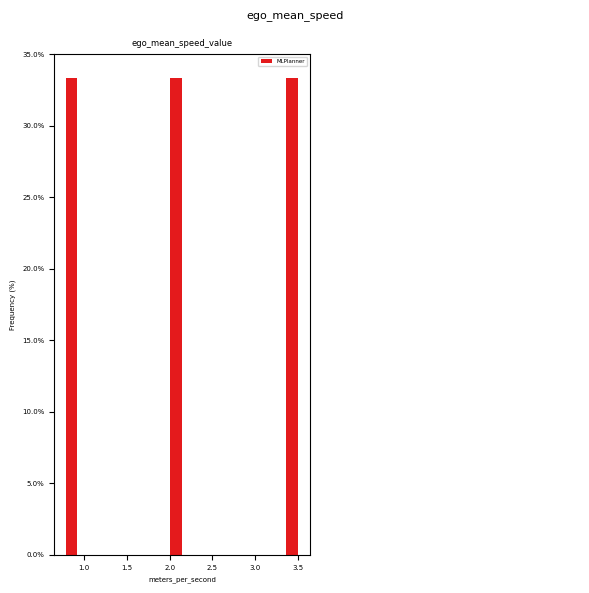

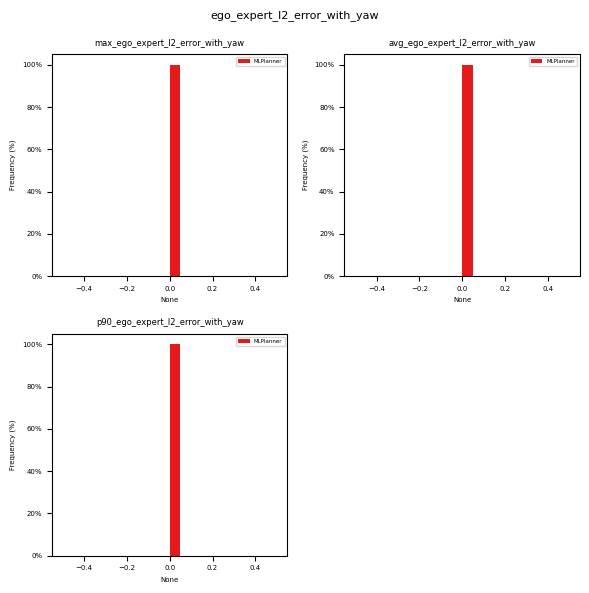

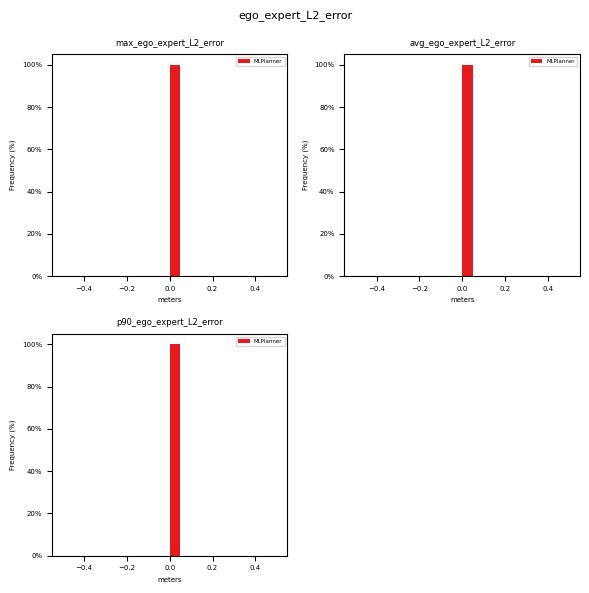

In [6]:
from nuplan.planning.script.run_simulation import run_simulation as main_simulation

planner = MLPlanner(model)

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg, planner)

In [7]:
# Get nuBoard simulation file for visualization later on
simulation_file = [str(file) for file in Path(cfg.output_dir).iterdir() if file.is_file() and file.suffix == '.nuboard']

In [ ]:
from tutorials.utils.tutorial_utils import construct_nuboard_hydra_paths

# Location of paths with all nuBoard configs
nuboard_hydra_paths = construct_nuboard_hydra_paths(BASE_CONFIG_PATH)

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=nuboard_hydra_paths.config_path)

# Compose the configuration
cfg = hydra.compose(config_name=nuboard_hydra_paths.config_name, overrides=[
    'scenario_builder=nuplan_mini',  # set the database (same as simulation) used to fetch data for visualization
    f'simulation_path={simulation_file}',  # nuboard file path, if left empty the user can open the file inside nuBoard
    f'hydra.searchpath=[{nuboard_hydra_paths.common_dir}, {nuboard_hydra_paths.experiment_dir}]',
])

from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

INFO:bokeh.server.server:Starting Bokeh server version 2.4.3 (running on Tornado 6.3.2)
INFO:bokeh.server.tornado:User authentication hooks NOT provided (default user enabled)


2023-07-25 13:47:50,721 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-07-25 13:47:50,733 INFO {/home/nishka/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-07-25 13:47:50,734 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2023-07-25 13:47:50,734 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2023-07-25 13:47:51,093 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2023-07-25 13:47:51,103 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0014 seconds.
2023-07-25 13:47:51,239 INFO {/home/nishka/.local/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /

INFO:tornado.access:200 GET / (127.0.0.1) 199.58ms
INFO:tornado.access:200 GET /resource/motional_logo.png (127.0.0.1) 7.83ms
INFO:tornado.access:101 GET /ws (127.0.0.1) 0.98ms
INFO:bokeh.server.views.ws:WebSocket connection opened
INFO:bokeh.server.views.ws:ServerConnection created


2023-07-25 13:47:51,302 INFO {/home/nishka/.local/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/motional_logo.png (127.0.0.1) 7.83ms
2023-07-25 13:47:51,444 WARNING {/home/nishka/.local/lib/python3.9/site-packages/tornado/web.py:2344}  404 GET /favicon.ico (127.0.0.1) 0.64ms
2023-07-25 13:47:51,452 INFO {/home/nishka/.local/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.98ms


Rendering a scenario: 100%|███████████████████████| 1/1 [00:00<00:00, 20.00it/s]


2023-07-25 13:48:24,080 INFO {/home/nishka/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 3.2372 seconds.
